In [1]:
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

# Define File Paths
Define the file paths for the first FITS files in each folder (g, ir, r, u).

In [2]:
folder_names = ['g', 'ir', 'r', 'u']
base_path = './../dataset'
prefix = 'PGC0000218'

file_paths = {}
for folder in folder_names:
    folder_path = os.path.join(base_path, folder)
    if os.path.exists(folder_path) and os.path.isdir(folder_path):
        files = os.listdir(folder_path)
        for file in files:
            if file.startswith(prefix):
                file_paths[folder] = os.path.join(folder_path, file)
                break
        else:
            print(f"No files starting with {prefix} found in directory: {folder_path}")
    else:
        print(f"Directory does not exist: {folder_path}")

print(file_paths)

{'g': './../dataset/g/PGC0000218_g.fits', 'ir': './../dataset/ir/PGC0000218_i.fits', 'r': './../dataset/r/PGC0000218_r.fits', 'u': './../dataset/u/PGC0000218_u.fits'}


# Load FITS Files
Use astropy.io.fits to open and load the data from the FITS files.

In [3]:
fits_data = {folder: fits.getdata(file_paths[folder]) for folder in folder_names}

for folder in folder_names:
    print(f"{folder} filter data shape: {fits_data[folder].shape}")

g filter data shape: (255, 255)
ir filter data shape: (255, 255)
r filter data shape: (255, 255)
u filter data shape: (255, 255)


# Statistical analysis
As you can see in the first line of the plot, the raw images doesn't give lots of visual information about the galaxies : the information is hidden because of very hot pixels that changes the intensity scale. Because of them, we cannot see the variations of intensity in the galaxy itself and with its background.
We can also note that for the 'u' filter (ultraviolet), the values have much less dispersion compared to the other filters.

Hence, we can perform a very simple statistical analysis to adress this issue.

First, we plot in the second line of the plot an histogram showing the pixels values repartition, for each filter. We can see that for all the filters, the huge majority of the pixels values is concentrated clos to the 0 than to the higher values (due to the dark background).

The hot pixels may be due to the camera itself, and it is no big deal to get rid of these wrong pixels.

In the rest of the plot, for each line, we put a maximum threshold equals to the valuie of the corresponding percentile.

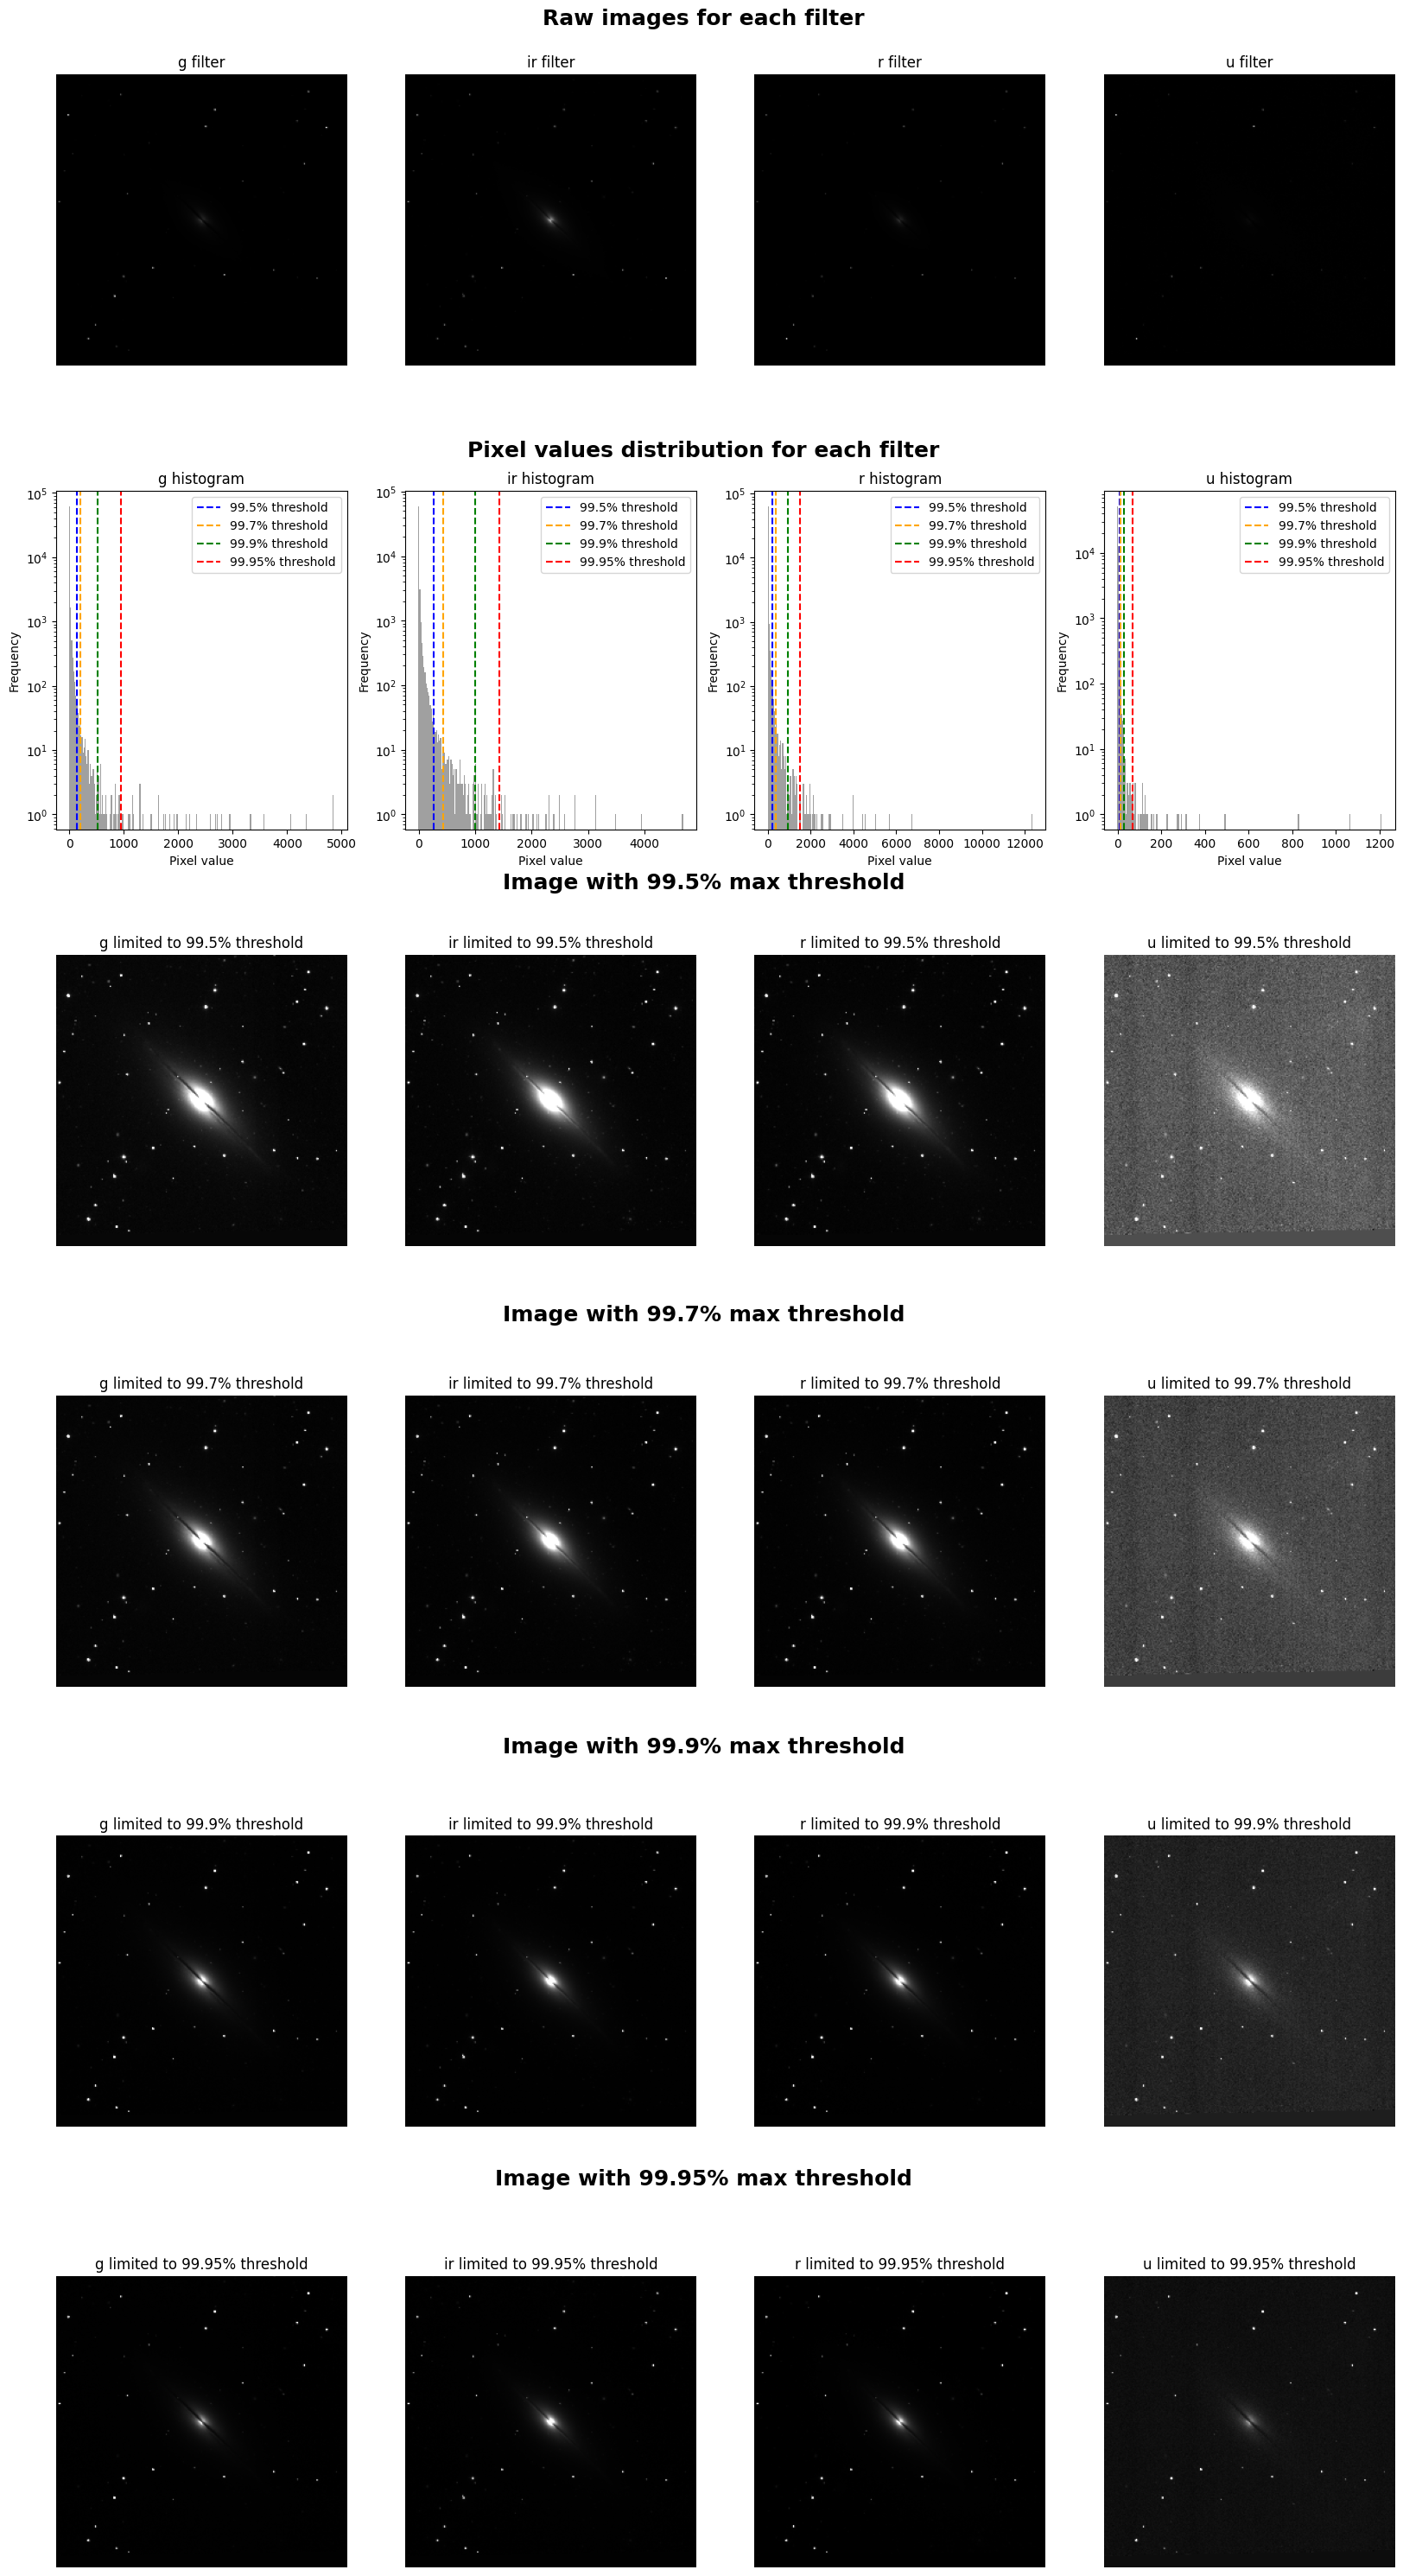

In [4]:
percentiles = [99.5, 99.7, 99.9, 99.95]
colors = ['blue', 'orange', 'green', 'red']
titles = ["Raw images for each filter", "Pixel values distribution for each filter"]
titles += [f"Image with {pct}% max threshold" for pct in percentiles]

fig, axes = plt.subplots(6, 4, figsize=(20, 30))

plt.subplots_adjust(top=0.99, bottom=0.01, hspace=0.3)

for idx, title in enumerate(titles):
    y_pos = 1 - (idx / 6) # Ajustement de la position en hauteur
    fig.text(0.5, y_pos, title, ha='center', fontsize=18, fontweight='bold')

for i, folder in enumerate(folder_names):
    # RAW images
    ax_img = axes[0, i]
    ax_img.imshow(fits_data[folder], cmap='gray')
    ax_img.set_title(f"{folder} filter")
    ax_img.axis('off')
    
    # Histograms
    ax_hist = axes[1, i]
    pixel_values = fits_data[folder].ravel()
    ax_hist.hist(pixel_values, bins=256, color='gray', alpha=0.75)
    ax_hist.set_title(f"{folder} histogram")
    ax_hist.set_xlabel('Pixel value')
    ax_hist.set_ylabel('Frequency')
    ax_hist.set_yscale('log')
    
    # Vertical lines for the percentiles
    for pct, color in zip(percentiles, colors):
        value = np.percentile(pixel_values, pct)
        ax_hist.axvline(value, color=color, linestyle='--', label=f'{pct}% threshold')
        ax_hist.legend(loc='upper right')
    
    # Images with threshold
    for j, (pct, color) in enumerate(zip(percentiles, colors)):
        ax_img_limited = axes[j + 2, i]
        threshold = np.percentile(pixel_values, pct)
        limited_image = np.clip(fits_data[folder], None, threshold)
        ax_img_limited.imshow(limited_image, cmap='gray')
        ax_img_limited.set_title(f"{folder} limited to {pct}% threshold")
        ax_img_limited.axis('off')

plt.show()


# Searching for outliers

The idea in this part is to get rid of the images that are too hard to classify (i.e. if a star is way too bright and covers the galaxy, ...). To do so, we calculate statistics for each image in each filter, and then search for the outliers.

We may choose to exclude from the analysis the images that were considered outliers in 3 filters or more, for 2 at least statistics.

In [5]:
def calculate_statistics(image_data):
    stats = {
        'mean': np.mean(image_data),
        'std': np.std(image_data),
        'min': np.min(image_data),
        '25%': np.percentile(image_data, 25),
        '50%': np.percentile(image_data, 50),
        '75%': np.percentile(image_data, 75),
        'max': np.max(image_data)
    }
    
    return stats

def process_dataset(dataset_path):
    results = []
    
    for root, dirs, files in os.walk(dataset_path):
        for file in files:
            if file.endswith('.fits'):
                file_path = os.path.join(root, file)
                with fits.open(file_path) as hdul:
                    image_data = hdul[0].data
                    stats = calculate_statistics(image_data)
                    stats['file'] = os.path.basename(file_path)
                    stats['filter'] = file.split('_')[-1].split('.')[0]  # Extract filter from filename
                    results.append(stats)
    
    df = pd.DataFrame(results)
    df = df[['file', 'filter', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']]
    return df

dataset_path = './../dataset'
df = process_dataset(dataset_path)

csv_path = 'image_statistics.csv'
df.to_csv(csv_path, index=False)
print(f"Results saved to {csv_path}")

Results saved to image_statistics.csv


Here, we take the csv we just created to plot boxplots for each statistic and all filters mixed. 

We save the outliers in another csv, putting 1 for a specific statistic if the image (in its filter) is an outlier for that statistic.

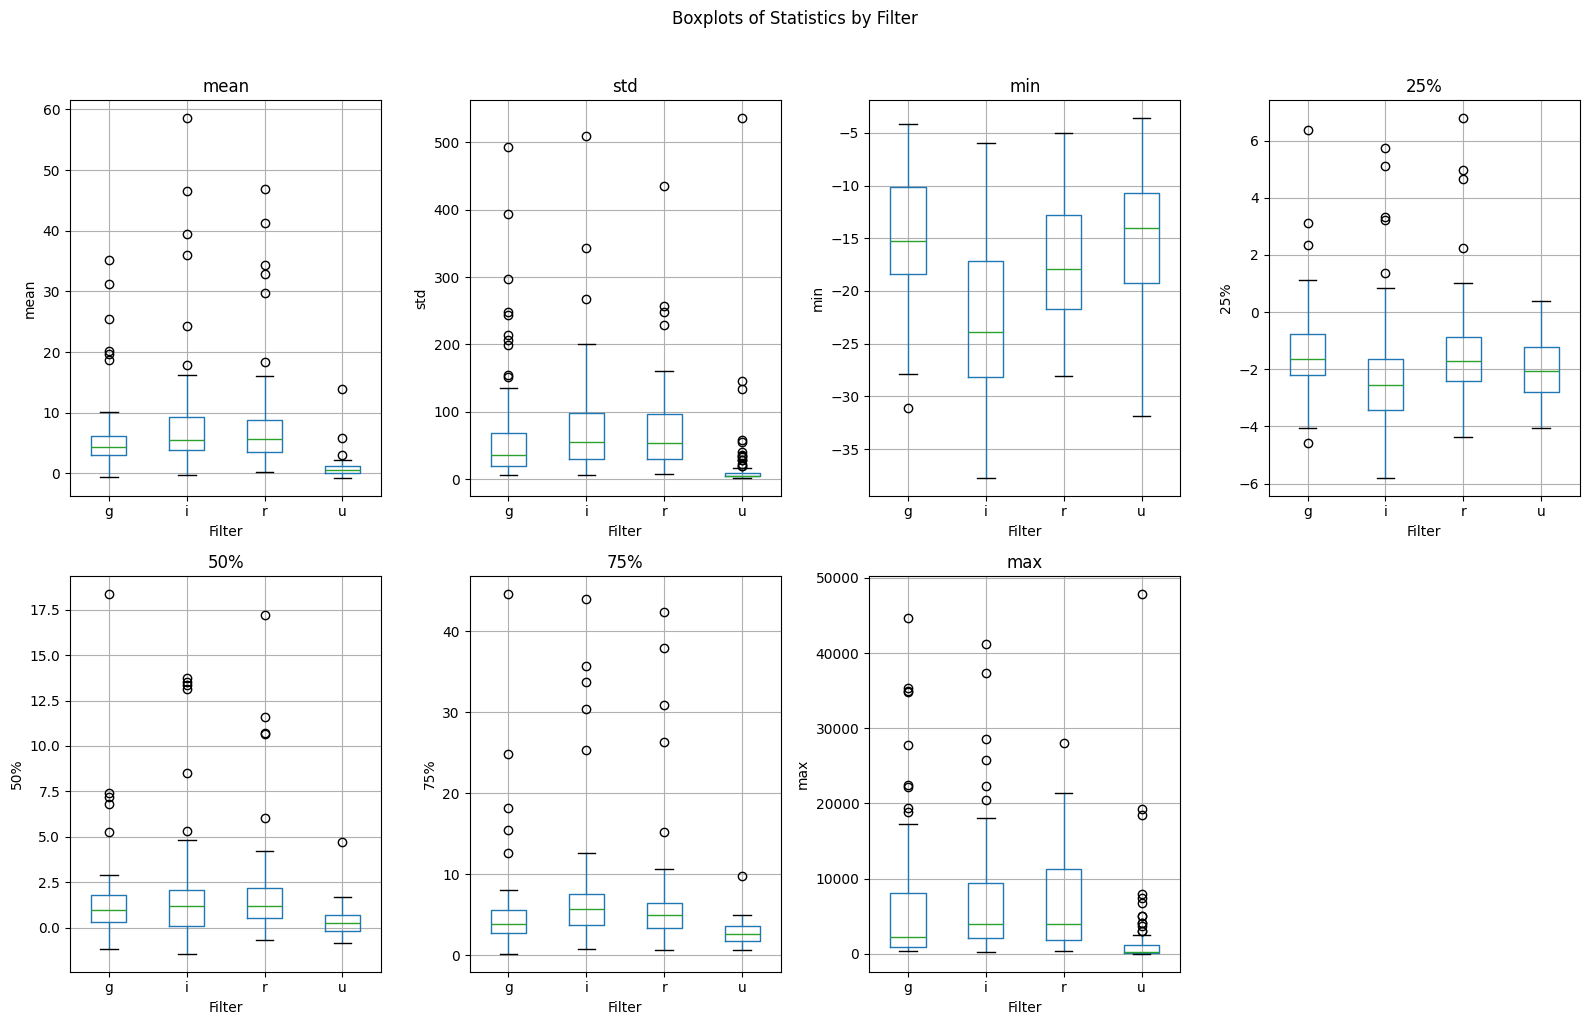

In [6]:
df = pd.read_csv("image_statistics.csv")

statistics = ["mean", "std", "min", "25%", "50%", "75%", "max"]

outliers_df = pd.DataFrame(columns=["file"] + statistics)
outliers_df.set_index("file", inplace=True)

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16, 10))
axes = axes.flatten()

for i, stat in enumerate(statistics):
    Q1 = df.groupby("filter")[stat].quantile(0.25)
    Q3 = df.groupby("filter")[stat].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    for filter_val in df["filter"].unique():
        filter_outliers = df[(df["filter"] == filter_val) & 
                             ((df[stat] < lower_bound[filter_val]) | 
                              (df[stat] > upper_bound[filter_val]))]

        for file in filter_outliers["file"]:
            if file not in outliers_df.index:
                outliers_df.loc[file] = [False] * len(statistics)
            outliers_df.at[file, stat] = True

    df.boxplot(column=stat, by="filter", ax=axes[i])
    axes[i].set_title(stat)
    axes[i].set_xlabel("Filter")
    axes[i].set_ylabel(stat)

fig.delaxes(axes[-1])

plt.tight_layout()
plt.suptitle("Boxplots of Statistics by Filter", y=1.02)  # Titre global
plt.show()

outliers_df.fillna(False, inplace=True)
outliers_df = outliers_df.astype(int) # Convert true/false to 1/0

outliers_df.to_csv("outliers_by_statistic.csv")

Outlier images if they are outliers in 4, 3, 2 or 1 filter.

We can see that some images looks "good enough" to be used in the project, so we may add another constraint in the next cell.

In [7]:
df = pd.read_csv('outliers_by_statistic.csv')

df['file_name'] = df['file'].apply(lambda x: x.split('_')[0])
df['filter'] = df['file'].apply(lambda x: x.split('_')[1].split('.')[0])

filter_counts = df.groupby('file_name')['filter'].nunique()

files_4_filters = filter_counts[filter_counts == 4].index.tolist()
files_3_filters = filter_counts[filter_counts == 3].index.tolist()
files_2_filters = filter_counts[filter_counts == 2].index.tolist()
files_1_filter = filter_counts[filter_counts == 1].index.tolist()

print("Outliers in 4 filters :", files_4_filters)
print("Outliers in 3 filters :", files_3_filters)
print("Outliers in 2 filters :", files_2_filters)
print("Outliers in 1 filters :", files_1_filter)

Outliers in 4 filters : ['PGC0000281', 'PGC0000825', 'PGC0003072']
Outliers in 3 filters : ['PGC0001221', 'PGC0001293', 'PGC0001309', 'PGC0001805', 'PGC0002332', 'PGC0003451', 'PGC0003563']
Outliers in 2 filters : ['PGC0000255', 'PGC0000963', 'PGC0001933', 'PGC0002269']
Outliers in 1 filters : ['PGC0000212', 'PGC0000282', 'PGC0000647', 'PGC0001932', 'PGC0002035', 'PGC0002149', 'PGC0002182', 'PGC0002889', 'PGC0003377']


We only keep the outliers that are marked as so in 2 or more statistics.

In [8]:
df = pd.read_csv('outliers_by_statistic.csv')

df['file_name'] = df['file'].apply(lambda x: x.split('_')[0])
df['filter'] = df['file'].apply(lambda x: x.split('_')[1].split('.')[0])

df['outlier_count'] = df.iloc[:, 1:-2].sum(axis=1)

df_filtered = df[df['outlier_count'] >= 2]

filter_counts = df_filtered.groupby('file_name')['filter'].nunique()

files_4_filters = filter_counts[filter_counts == 4].index.tolist()
files_3_filters = filter_counts[filter_counts == 3].index.tolist()
files_2_filters = filter_counts[filter_counts == 2].index.tolist()
files_1_filter = filter_counts[filter_counts == 1].index.tolist()

print("Outliers in 4 filters :", files_4_filters)
print("Outliers in 3 filters :", files_3_filters)
print("Outliers in 2 filters :", files_2_filters)
print("Outliers in 1 filter  :", files_1_filter)

Outliers in 4 filters : ['PGC0000281', 'PGC0000825']
Outliers in 3 filters : ['PGC0001221', 'PGC0001309', 'PGC0002332', 'PGC0003451']
Outliers in 2 filters : ['PGC0001805', 'PGC0002269', 'PGC0003072', 'PGC0003563']
Outliers in 1 filter  : ['PGC0000212', 'PGC0000255', 'PGC0000963', 'PGC0001293', 'PGC0001932', 'PGC0001933', 'PGC0002035', 'PGC0002149', 'PGC0002182', 'PGC0003377']


I let you go to the png folder and chechk the images outputed as outliers.

It looks like a good idea to exclude the outliers in 4 and 3 filters for at least 2 statistics.

# Checking the SNR

In [50]:
def compute_snr(image_data):
    signal = np.mean(image_data)
    noise = np.std(image_data)
    snr = signal / noise
    return snr

In [51]:
def apply_percentile_threshold(image_data, percentile=99.7):
    threshold_value = np.percentile(image_data, percentile)
    
    return np.clip(image_data, None, threshold_value)


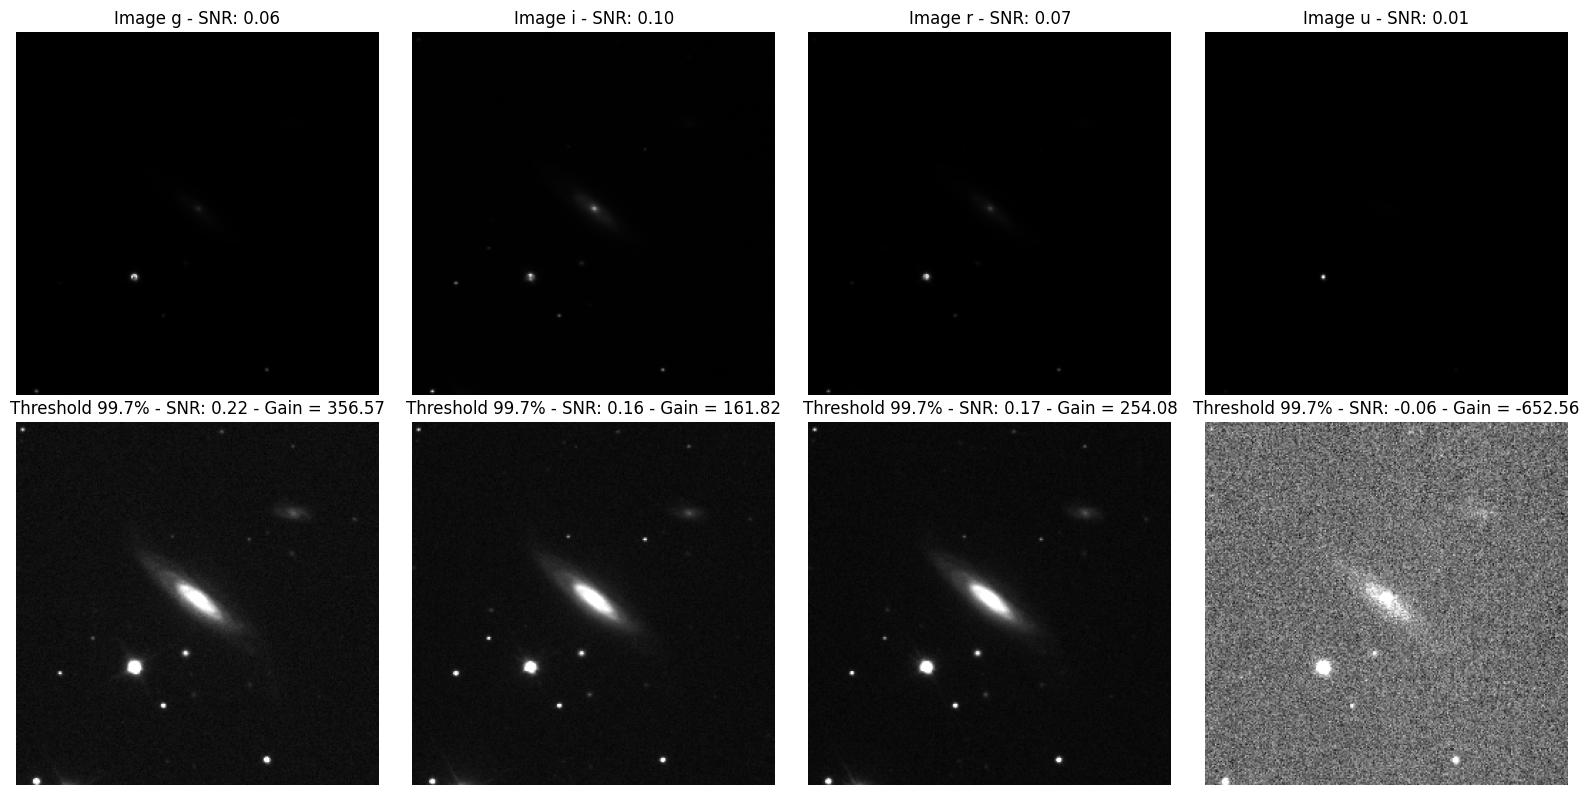

In [52]:
def plot_images_with_percentile(galaxy):
    
    start = "./../dataset/"
    fits_files = [f"{start}{folder}/{galaxy}_{folder}.fits" for folder in ['g', 'i', 'r', 'u']]
    
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    
    filters = ['g', 'i', 'r', 'u']
    
    for i, fits_file in enumerate(fits_files):
        hdul = fits.open(fits_file)
        image_data = hdul[0].data
        
        original_snr = compute_snr(image_data)
        
        percentile = 99.7
        scaled_image = apply_percentile_threshold(image_data, percentile)
        scaled_snr = compute_snr(scaled_image)
        
        ax = axes[0, i]
        ax.imshow(image_data, cmap='gray', origin='lower')
        ax.set_title(f'Image {filters[i]} - SNR: {original_snr:.2f}')
        ax.axis('off')
        
        ax = axes[1, i]
        ax.imshow(scaled_image, cmap='gray', origin='lower')
        ax.set_title(f'Threshold {percentile}% - SNR: {scaled_snr:.2f} - Gain = {scaled_snr / original_snr * 100:.2f}')
        ax.axis('off')
            
    plt.tight_layout()
    plt.show()

galaxy = 'PGC0000212'
plot_images_with_percentile(galaxy)

We can see that the SNR has improved by adding the threshold to the images. But the SNR's improvement is only effective for g, i and r, wheras for u, it has drastically worsen.

But at least for u, we can see the galaxy ; before it was just full dakness.

# Adaptative filtering

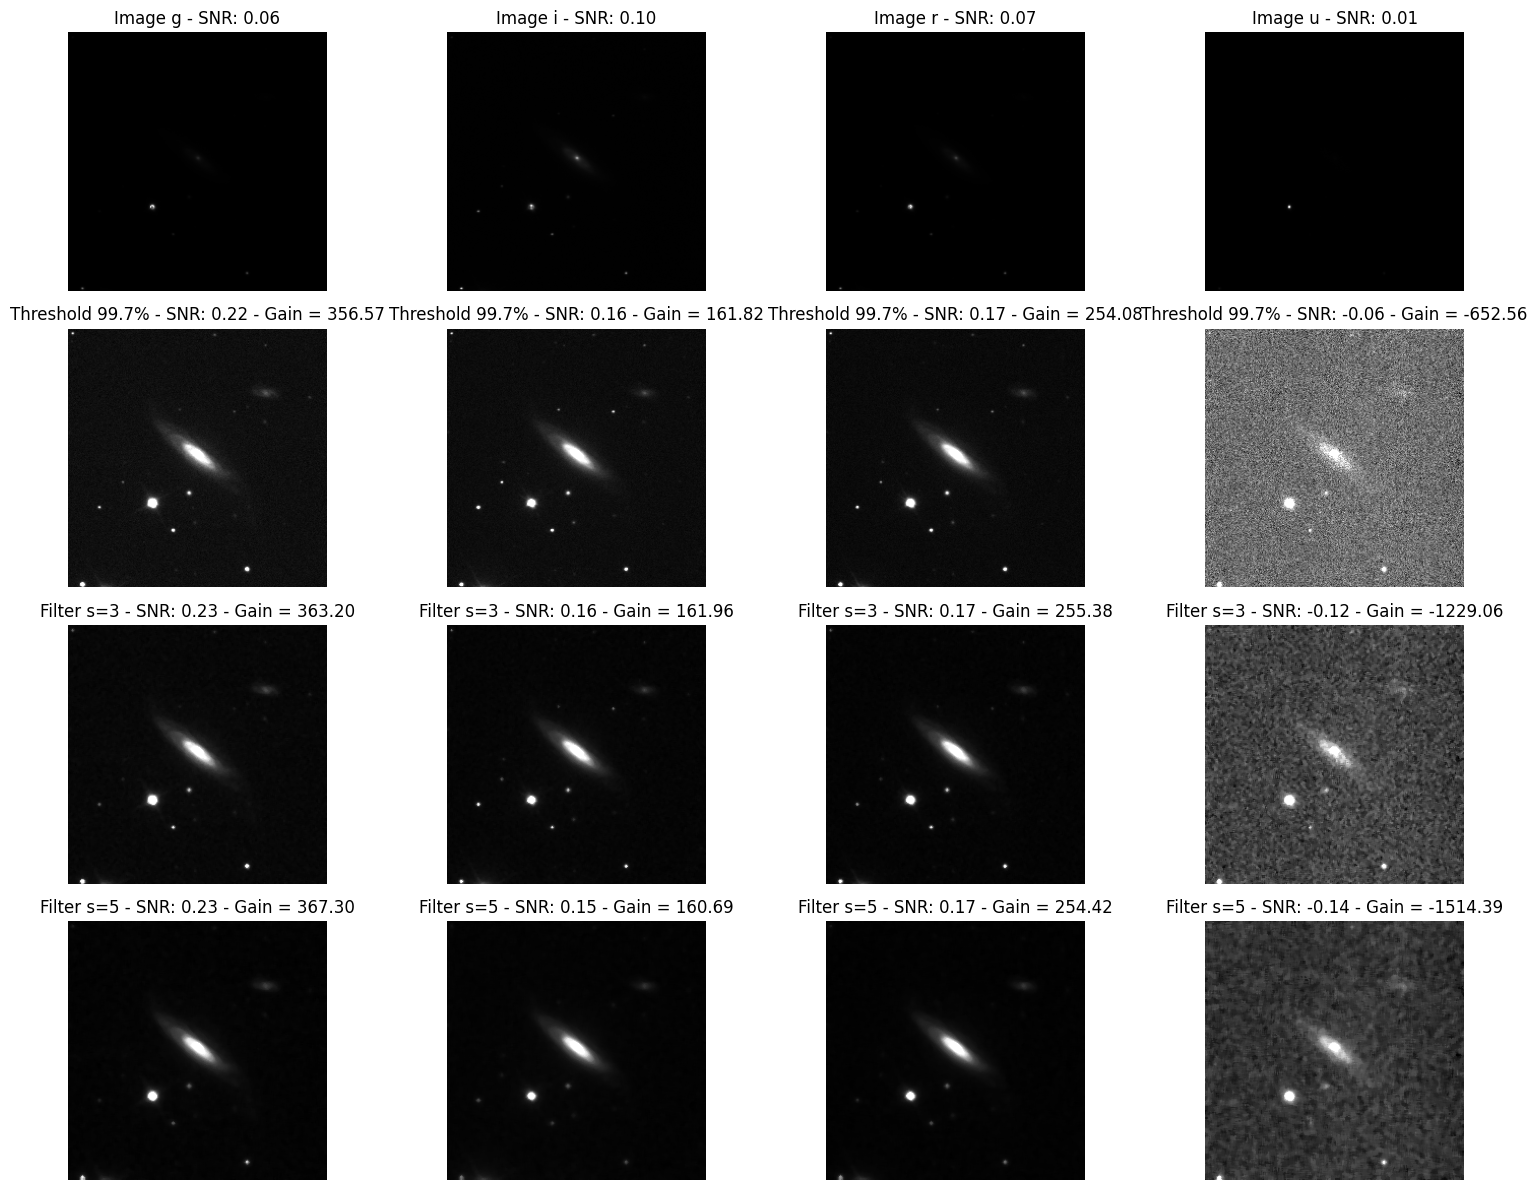

In [57]:
from scipy.ndimage import median_filter

def apply_adaptive_filtering(image_data, size=3):
    return median_filter(image_data, size=size)

def plot_images_with_percentile(galaxy):
    start = "./../dataset/"
    fits_files = [f"{start}{folder}/{galaxy}_{folder}.fits" for folder in ['g', 'i', 'r', 'u']]
    
    fig, axes = plt.subplots(4, 4, figsize=(16, 12))
    
    filters = ['g', 'i', 'r', 'u']
    
    for i, fits_file in enumerate(fits_files):
        hdul = fits.open(fits_file)
        image_data = hdul[0].data
        
        original_snr = compute_snr(image_data)
        
        percentile = 99.7
        scaled_image = apply_percentile_threshold(image_data, percentile)
        scaled_snr = compute_snr(scaled_image)
        
        ax = axes[0, i]
        ax.imshow(image_data, cmap='gray', origin='lower')
        ax.set_title(f'Image {filters[i]} - SNR: {original_snr:.2f}')
        ax.axis('off')
        
        ax = axes[1, i]
        ax.imshow(scaled_image, cmap='gray', origin='lower')
        ax.set_title(f'Threshold {percentile}% - SNR: {scaled_snr:.2f} - Gain = {scaled_snr / original_snr * 100:.2f}')
        ax.axis('off')

        size = 3
        filtered_image = apply_adaptive_filtering(scaled_image, size=size)
        filtered_snr = compute_snr(filtered_image)
        
        ax = axes[2, i]
        ax.imshow(filtered_image, cmap='gray', origin='lower')
        ax.set_title(f'Filter s={size} - SNR: {filtered_snr:.2f} - Gain = {filtered_snr / original_snr * 100:.2f}')
        ax.axis('off')
        
        size = 5
        filtered_image = apply_adaptive_filtering(scaled_image, size=size)
        filtered_snr = compute_snr(filtered_image)
        
        ax = axes[3, i]
        ax.imshow(filtered_image, cmap='gray', origin='lower')
        ax.set_title(f'Filter s={size} - SNR: {filtered_snr:.2f} - Gain = {filtered_snr / original_snr * 100:.2f}')
        ax.axis('off')
            
    plt.tight_layout()
    plt.show()

galaxy = 'PGC0000212'
plot_images_with_percentile(galaxy)


# Galaxy's surface

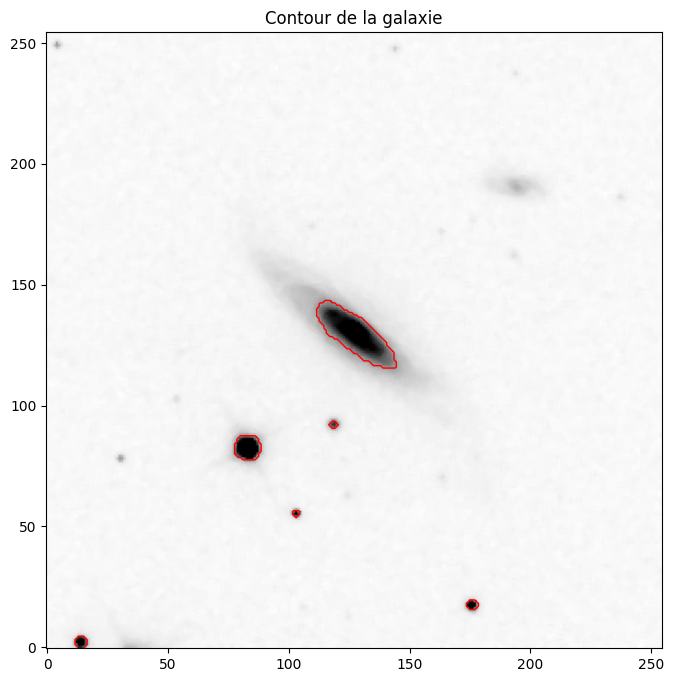

In [73]:
from skimage.measure import find_contours
from skimage.filters import threshold_otsu

image_path = './../dataset/g/PGC0000212_g.fits'
hdu_list = fits.open(image_path)
image_data = hdu_list[0].data

image_data = apply_percentile_threshold(image_data, percentile=99.7)
image_data = apply_adaptive_filtering(image_data, size=3)

image_data = np.max(image_data) - image_data

# image_data = np.log1p(image_data) 

thresh = threshold_otsu(image_data)
binary_image = image_data > thresh

contours = find_contours(binary_image, level=0.5) 

# Visualiser l'image et les contours
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(image_data, cmap='gray', origin='lower') 

for contour in contours:
    ax.plot(contour[:, 1], contour[:, 0], color='red', lw=1)

ax.set_title('Contour de la galaxie')
plt.show()
